# Evolución del Tour de Francia (1903 - 2025)
**Análisis del cambio de paradigma: De la supervivencia a la optimización fisiológica.**

En este notebook orquestamos el pipeline de datos completo, desde la ingesta de los datos crudos hasta el análisis exploratorio (EDA), utilizando código modular importado de nuestra carpeta `src/`.


Empezamos con las importaciones de lo que vamos a necesitar

In [1]:
import sys
import os

# Obtener la ruta del directorio actual del notebook
current_notebook_dir = os.getcwd()

# La raíz del proyecto está un nivel por encima del directorio 'notebooks'
project_root = os.path.abspath(os.path.join(current_notebook_dir, '..'))

# Añadir la raíz del proyecto al sys.path si no está ya presente
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Ahora se puede importar desde src/
import src.cleaning as cln
import src.features as feat
import src.io as io
import src.viz as viz

# Ignorar warnings de pandas para una presentación limpia
import warnings
warnings.filterwarnings('ignore')


## 1. Pipeline de Procesamiento de Datos
Para mantener este notebook limpio, hemos encapsulado las lógicas de limpieza y cálculo de variables en los módulos `cleaning.py` y `features.py`. A continuación, ejecutamos el pipeline:

In [2]:
# Empezamos extrayendo y limpiando tdf_stages_master y comparandolo
df_raw_stages = pd.read_csv('../data/raw/tdf_stages_master.csv')
display (df_raw_stages.info())
display (df_raw_stages.head(5))

df_stages_clean = cln.clean_stages(df_raw_stages)
display (df_raw_stages.info())
display (df_raw_stages.head(5))

NameError: name 'pd' is not defined

In [ ]:
# Continuamos con tdf_tours_master
df_raw_tours = pd.read_csv('../data/raw/tdf_tours_master.csv')
display (df_raw_tours.info())
display (df_raw_tours.head(5))

df_tours_clean = cln.clean_tours(df_raw_tours)
display (df_tours_clean.info())
display (df_tours_clean.head(5))

<class 'pandas.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Year       112 non-null    int64
 1   Dates      112 non-null    str  
 2   Stages     112 non-null    str  
 3   Distance   112 non-null    str  
 4   Starters   112 non-null    int64
 5   Finishers  112 non-null    int64
dtypes: int64(3), str(3)
memory usage: 5.4 KB


None

,Year,Dates,Stages,Distance,Starters,Finishers
0,1903,119 July 1903,6,"2,428 km (1,509 mi)",60,21
1,1904,224 July 1904,6,"2,428 km (1,509 mi)",88,15
2,1905,930 July 1905,11,"2,994 km (1,860 mi)",60,24
3,1906,429 July 1906,13,"4,637 km (2,881 mi)",82,14
4,1907,8 July  4 August 1907,14,"4,488 km (2,789 mi)",93,33


<class 'pandas.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year                 112 non-null    int64  
 1   dates                112 non-null    str    
 2   stages               112 non-null    int64  
 3   stages_observations  53 non-null     str    
 4   distance_in_km       112 non-null    float64
 5   starters             112 non-null    int64  
 6   finishers            112 non-null    int64  
 7   abandon_rate         112 non-null    float64
dtypes: float64(2), int64(4), str(2)
memory usage: 7.1 KB


None

,year,dates,stages,stages_observations,distance_in_km,starters,finishers,abandon_rate
0,1903,De 01/07 a 19/07,6,NaN,2428.0,60,21,0.65
1,1904,De 02/07 a 24/07,6,NaN,2428.0,88,15,0.83
2,1905,De 09/07 a 30/07,11,NaN,2994.0,60,24,0.60
3,1906,De 04/07 a 29/07,13,NaN,4637.0,82,14,0.83
4,1907,De 08/07 a 04/08,14,NaN,4488.0,93,33,0.65


In [ ]:
# Continuamos ahora con tdf_winners_master
df_raw_winners = pd.read_csv('../data/raw/tdf_winners_master.csv')
display (df_raw_winners.info())
display (df_raw_winners.head(5))

df_winners_clean = cln.clean_winners(df_raw_winners)
display (df_winners_clean.info())
display (df_winners_clean.head(5))

<class 'pandas.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Year        105 non-null    int64  
 1   Country     105 non-null    str    
 2   Rider       105 non-null    str    
 3   Team        105 non-null    str    
 4   Time        97 non-null     str    
 5   Margin      97 non-null     str    
 6   Stages Won  105 non-null    int64  
 7   Stages Led  102 non-null    float64
 8   Avg Speed   97 non-null     str    
 9   Height      65 non-null     str    
 10  Weight      66 non-null     str    
 11  Born        105 non-null    str    
 12  Died        56 non-null     str    
dtypes: float64(1), int64(2), str(10)
memory usage: 10.8 KB


None

,Year,Country,Rider,Team,Time,Margin,Stages Won,Stages Led,Avg Speed,Height,Weight,Born,Died
0,1903,France,Maurice Garin,La Française,"94h 33' 14""","+ 2h 59' 21""",3,6.0,25.7km/h,1.62m,60kg,1871-03-03,1957-02-19
1,1904,France,Henri Cornet,Conte,"96h 05' 55""","+ 2h 16' 14""",1,3.0,25.3km/h,NaN,NaN,1884-08-04,1941-03-18
2,1905,France,Louis Trousselier,PeugeotWolber,NaN,NaN,5,10.0,NaN,NaN,NaN,1881-06-29,1939-04-24
3,1906,France,René Pottier,PeugeotWolber,NaN,NaN,5,12.0,NaN,NaN,NaN,1879-06-05,1907-01-25
4,1907,France,Lucien Petit-Breton,PeugeotWolber,NaN,NaN,2,5.0,NaN,NaN,NaN,1882-10-18,1917-12-20


<class 'pandas.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   year        105 non-null    int64         
 1   stages won  105 non-null    int64         
 2   stages led  102 non-null    Int64         
 3   avg speed   97 non-null     float64       
 4   height      65 non-null     float64       
 5   weight      66 non-null     float64       
 6   born        105 non-null    datetime64[us]
dtypes: Int64(1), datetime64[us](1), float64(3), int64(2)
memory usage: 6.0 KB


None

,year,stages won,stages led,avg speed,height,weight,born
0,1903,3,6,25.7,1.62,60.0,1871-03-03
1,1904,1,3,25.3,NaN,NaN,1884-08-04
2,1905,5,10,NaN,NaN,NaN,1881-06-29
3,1906,5,12,NaN,NaN,NaN,1879-06-05
4,1907,2,5,NaN,NaN,NaN,1882-10-18


In [ ]:
# Finalzamos con tdf_finishers_master
df_raw_finishers = pd.read_csv('../data/raw/tdf_finishers_master.csv')
display (df_raw_finishers.info())
display (df_raw_finishers.head(5))

df_finishers_clean = cln.clean_finishers(df_raw_finishers)
display (df_finishers_clean.info())
display (df_finishers_clean.head(5))

<class 'pandas.DataFrame'>
RangeIndex: 10344 entries, 0 to 10343
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Year    10344 non-null  int64
 1   Rank    10344 non-null  str  
 2   Rider   10344 non-null  str  
 3   Time    10072 non-null  str  
 4   Team    10041 non-null  str  
dtypes: int64(1), str(4)
memory usage: 404.2 KB


None

,Year,Rank,Rider,Time,Team
0,1903,1,Maurice Garin (FRA),"94h 33' 14""",La Française
1,1903,2,Lucien Pothier (FRA),"+ 2h 59' 21""",La Française
2,1903,3,Fernand Augereau (FRA),"+ 4h 29' 24""",La Française
3,1903,4,Rodolfo Muller[27] (ITA),"+ 4h 39' 30""",La Française
4,1903,5,Jean Fischer (FRA),"+ 4h 58' 44""",La Française


<class 'pandas.DataFrame'>
RangeIndex: 10345 entries, 0 to 10344
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   year              10345 non-null  int64  
 1   rank              10345 non-null  int64  
 2   rider_name        10345 non-null  str    
 3   country           10345 non-null  str    
 4   team              10042 non-null  str    
 5   rider_total_time  10073 non-null  float64
dtypes: float64(1), int64(2), str(3)
memory usage: 485.1 KB


None

,year,rank,rider_name,country,team,rider_total_time
0,1903,1,Maurice Garin,Francia,La Française,340394.0
1,1903,2,Lucien Pothier,Francia,La Française,351155.0
2,1903,3,Fernand Augereau,Francia,La Française,356558.0
3,1903,4,Rodolfo Muller,Italia,La Française,357164.0
4,1903,5,Jean Fischer,Francia,La Française,358318.0


In [ ]:
#Creamos métricas de dureza y fisiología a través de los dataframes ya limpios.
df_stages_feat = feat.calculate_stage_workload(df_stages_clean)
df_analysis = feat.create_hardness_analysis(df_stages_feat, df_tours_clean, df_winners_clean)
df_winners_feat = feat.calculate_physiology(df_winners_clean)

display (df_stages_feat.info())
display (df_stages_feat.head(5))

display (df_analysis.info())
display (df_analysis.head(5))

display (df_winners_feat.info())
display (df_winners_feat.head(5))

<class 'pandas.DataFrame'>
RangeIndex: 2404 entries, 0 to 2403
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   year            2404 non-null   int64         
 1   date            2404 non-null   datetime64[us]
 2   stage           2404 non-null   str           
 3   course          2404 non-null   str           
 4   type            2404 non-null   str           
 5   distance_in_km  2404 non-null   float64       
 6   winner_name     2404 non-null   str           
 7   country         2355 non-null   str           
 8   stage_workload  2404 non-null   float64       
dtypes: datetime64[us](1), float64(2), int64(1), str(5)
memory usage: 169.2 KB


None

,year,date,stage,course,type,distance_in_km,winner_name,country,stage_workload
0,1903,1903-07-01,1,Paris to Lyon,Flat,467.0,Maurice Garin,Francia,93.4
1,1903,1903-07-05,2,Lyon to Marseille,Mountain,374.0,Hippolyte Aucouturier,Francia,374.0
2,1903,1903-07-08,3,Marseille to Toulouse,Flat,423.0,Hippolyte Aucouturier,Francia,84.6
3,1903,1903-07-12,4,Toulouse to Bordeaux,Flat,268.0,Charles Laeser,Suiza,53.6
4,1903,1903-07-13,5,Bordeaux to Nantes,Flat,425.0,Maurice Garin,Francia,85.0


<class 'pandas.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year                 112 non-null    int64  
 1   dates                112 non-null    str    
 2   stages               112 non-null    int64  
 3   stages_observations  53 non-null     str    
 4   distance_in_km       112 non-null    float64
 5   starters             112 non-null    int64  
 6   finishers            112 non-null    int64  
 7   abandon_rate         112 non-null    float64
 8   total_workload       112 non-null    float64
 9   actual_stages_count  112 non-null    int64  
 10  mountain_count       112 non-null    int64  
 11  mountain_percentage  112 non-null    float64
 12  avg speed            97 non-null     float64
 13  daily_intensity      112 non-null    float64
dtypes: float64(6), int64(6), str(2)
memory usage: 12.4 KB


None

,year,dates,stages,stages_observations,distance_in_km,starters,finishers,abandon_rate,total_workload,actual_stages_count,mountain_count,mountain_percentage,avg speed,daily_intensity
0,1903,De 01/07 a 19/07,6,NaN,2428.0,60,21,0.65,784.8,6,1,16.666667,25.7,130.800000
1,1904,De 02/07 a 24/07,6,NaN,2428.0,88,15,0.83,785.0,6,1,16.666667,25.3,130.833333
2,1905,De 09/07 a 30/07,11,NaN,2994.0,60,24,0.60,1121.8,11,2,18.181818,NaN,101.981818
3,1906,De 04/07 a 29/07,13,NaN,4637.0,82,14,0.83,1517.4,13,2,15.384615,NaN,116.723077
4,1907,De 08/07 a 04/08,14,NaN,4488.0,93,33,0.65,1876.8,14,4,28.571429,NaN,134.057143


<class 'pandas.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   year        105 non-null    int64         
 1   stages won  105 non-null    int64         
 2   stages led  102 non-null    Int64         
 3   avg speed   97 non-null     float64       
 4   height      65 non-null     float64       
 5   weight      66 non-null     float64       
 6   born        105 non-null    datetime64[us]
 7   bmi         65 non-null     float64       
 8   tour_date   105 non-null    datetime64[us]
 9   age         105 non-null    float64       
dtypes: Int64(1), datetime64[us](2), float64(5), int64(2)
memory usage: 8.4 KB


None

,year,stages won,stages led,avg speed,height,weight,born,bmi,tour_date,age
0,1903,3,6,25.7,1.62,60.0,1871-03-03,22.862369,1903-07-15,32.364134
1,1904,1,3,25.3,NaN,NaN,1884-08-04,NaN,1904-07-15,19.942505
2,1905,5,10,NaN,NaN,NaN,1881-06-29,NaN,1905-07-15,24.041068
3,1906,5,12,NaN,NaN,NaN,1879-06-05,NaN,1906-07-15,27.107461
4,1907,2,5,NaN,NaN,NaN,1882-10-18,NaN,1907-07-15,24.736482


## 2. Dimensión Física: Arquitectura y Dureza del Tour
**Pregunta 1:** ¿De qué está hecho el Tour? ¿Siempre ha sido una carrera de alta montaña o esto es un fenómeno moderno?

Para entender cómo ha evolucionado la dureza, no podemos medir solo los kilómetros totales. Hemos creado una métrica propia llamada **Índice de Dureza Ponderada**, que calcula la carga de trabajo de cada etapa multiplicando sus kilómetros por un coeficiente técnico según el terreno:

* **Fórmula:** `Carga de Etapa = Distancia (km) × Peso Técnico`
* **Pesos aplicados:**
  * Montaña (1.0): Máximo desgaste.
  * Media Montaña (0.7): Terreno rompepiernas constante.
  * Contrarreloj Individual (0.6): Esfuerzo aeróbico máximo.
  * Pavé / Contrarreloj Equipos (0.4): Alta tensión y desgaste.
  * Llano (0.2): Menor desgaste al rodar protegidos en el pelotón.

A continuación, agrupamos esta carga de trabajo por décadas para ver la evolución del diseño de la carrera.

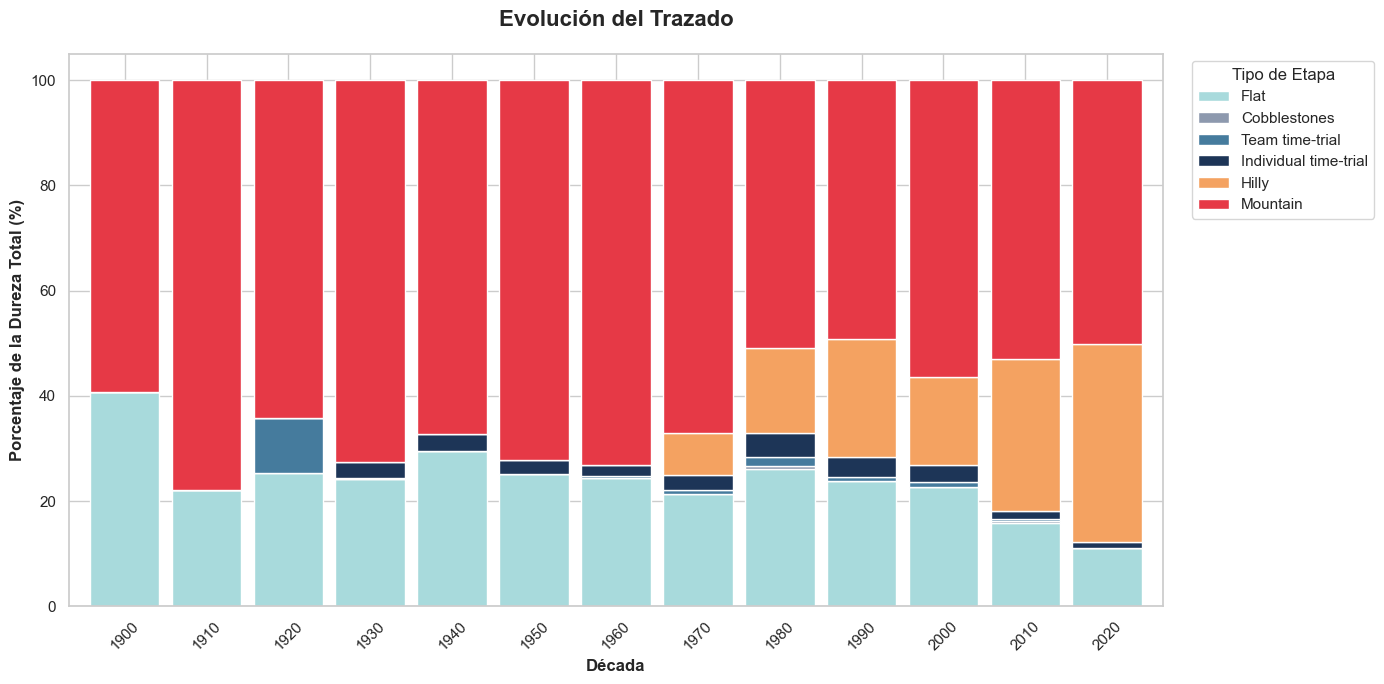

In [ ]:
# Gráfico 1: Composición del Esfuerzo por Década
viz.plot_hardness_composition(df_stages_feat)

* **Lectura del Gráfico:** Observamos claramente cómo en las primeras décadas (1900s - 1930s), más del 70% de la dureza provenía de interminables etapas llanas (color azul claro). Sin embargo, a medida que avanzamos hacia la actualidad, la alta montaña (rojo) y la media montaña (naranja) aumentan su importancia. Esto confirma que el Tour moderno está diseñado para castigar mediante el desnivel, no por la acumulación de kilómetros llanos.

### Volumen vs. Densidad
**Pregunta 2:** Si ahora hay más montaña, ¿qué ha pasado con los kilómetros totales? ¿Compensa una cosa a la otra?

Es muy común escuchar que el Tour "antes era mucho más duro" simplemente porque superaba los 5.000 kilómetros totales de recorrido. Para comprobar si esto es cierto o si es un mito, vamos a cruzar dos variables clave: la distancia total de cada edición frente al porcentaje de etapas de montaña (y media montaña) que la componen.

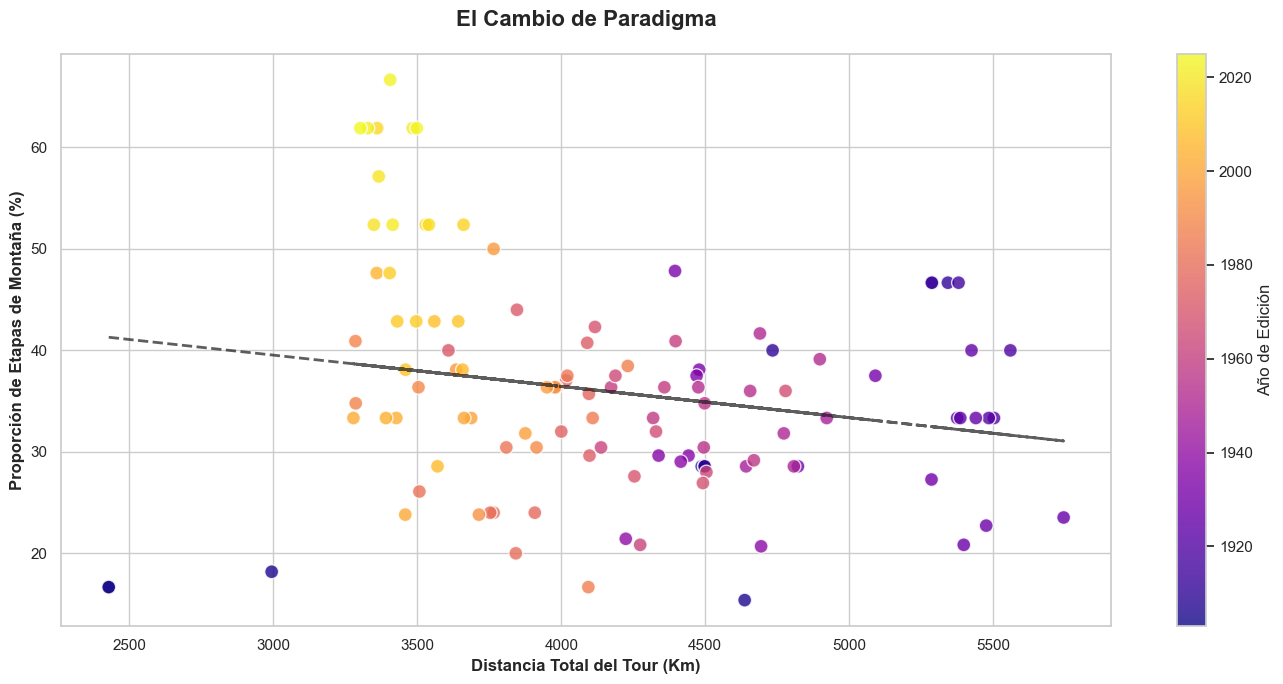

In [ ]:
# Gráfico 2: Relación entre distancia total y porcentaje de montaña
viz.plot_paradigm_shift(df_analysis)

* **Lectura del Gráfico:** Los datos confirman un cambio radical en el modelo de la carrera. La línea de tendencia muestra una correlación inversa de manual. Las ediciones de principios del siglo XX (puntos oscuros, abajo a la derecha) eran auténticos maratones de fondo, larguísimos pero casi planos. Sin embargo, el ciclismo actual (puntos amarillos, arriba a la izquierda) ha recortado unos 1.500 kilómetros del total para concentrar el esfuerzo: menos días de transición y hasta un 40% de etapas con desniveles importantes. Es el paso del ciclista "maratoniano" al escalador explosivo.

### La Paradoja de la Supervivencia
**Pregunta 3:** Si hemos demostrado que el Tour moderno es más intenso y tiene mucha más montaña, ¿significa esto que la carrera actual "destroza" a más ciclistas que en el pasado?

Para analizar esto, vamos a visualizar lo que llamo la "brecha de supervivencia". Representaremos el volumen total de ciclistas que toman la salida frente a los que logran cruzar la meta en París. El área que queda entre ambas métricas representa los abandonos, dándonos una medida muy visual del coste humano de la prueba a lo largo de la historia.

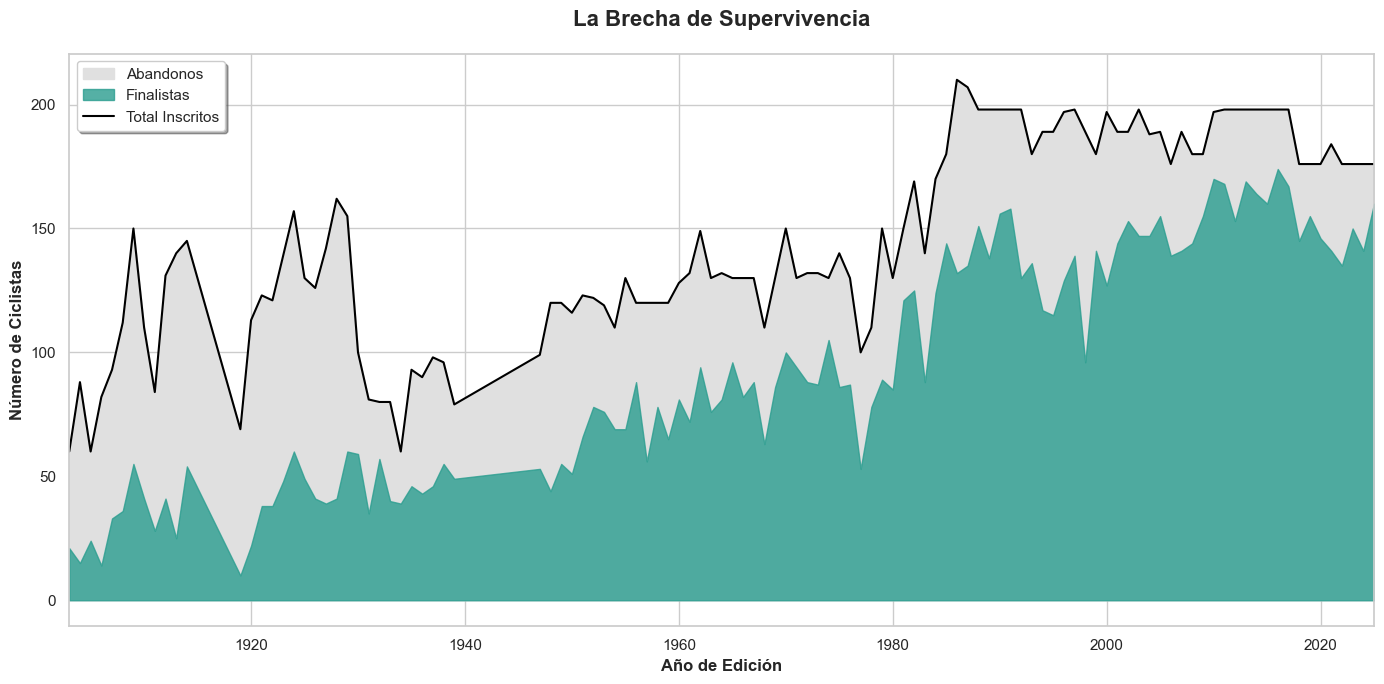

In [ ]:
# Gráfico 3: Evolución de inscritos vs. finalistas (área de abandonos)
viz.plot_survival_gap(df_analysis)

* **Lectura del Gráfico:** El resultado es fascinante porque rompe nuestra hipótesis inicial. Lo lógico sería pensar que a mayor intensidad técnica, más gente se retira. Sin embargo, el área gris (el porcentaje de abandonos) era inmensa en los años 20 y 30, y se ha ido comprimiendo hasta nuestros días, donde la inmensa mayoría del pelotón logra terminar. Esto demuestra que la carrera no se ha hecho más fácil, sino que la profesionalización (medicina, nutrición, entrenamiento por vatios y carreteras asfaltadas) ha elevado la capacidad de supervivencia del ciclista moderno muy por encima de la dureza del trazado.

## 3. Dimensión Fisiológica
### La Edad del Máximo Rendimiento
**Pregunta 4:** ¿Estamos viviendo una era sin precedentes de "niños prodigio" en el ciclismo o siempre ha habido campeones tan jóvenes?

Para analizar cómo ha evolucionado el perfil del campeón, cruzamos la fecha de nacimiento de cada ganador con el año de su victoria (fijando el 15 de julio como fecha central aproximada del Tour). Esto nos da la **edad exacta** del corredor en el momento de alzar el trofeo en París.

Tradicionalmente, la ciencia deportiva establecía que un ciclista de grandes vueltas alcanzaba su "Edad de Oro" (el pico de madurez muscular y resistencia psicológica) entre los 26 y 29 años. Vamos a comprobar si la historia respalda esta teoría.

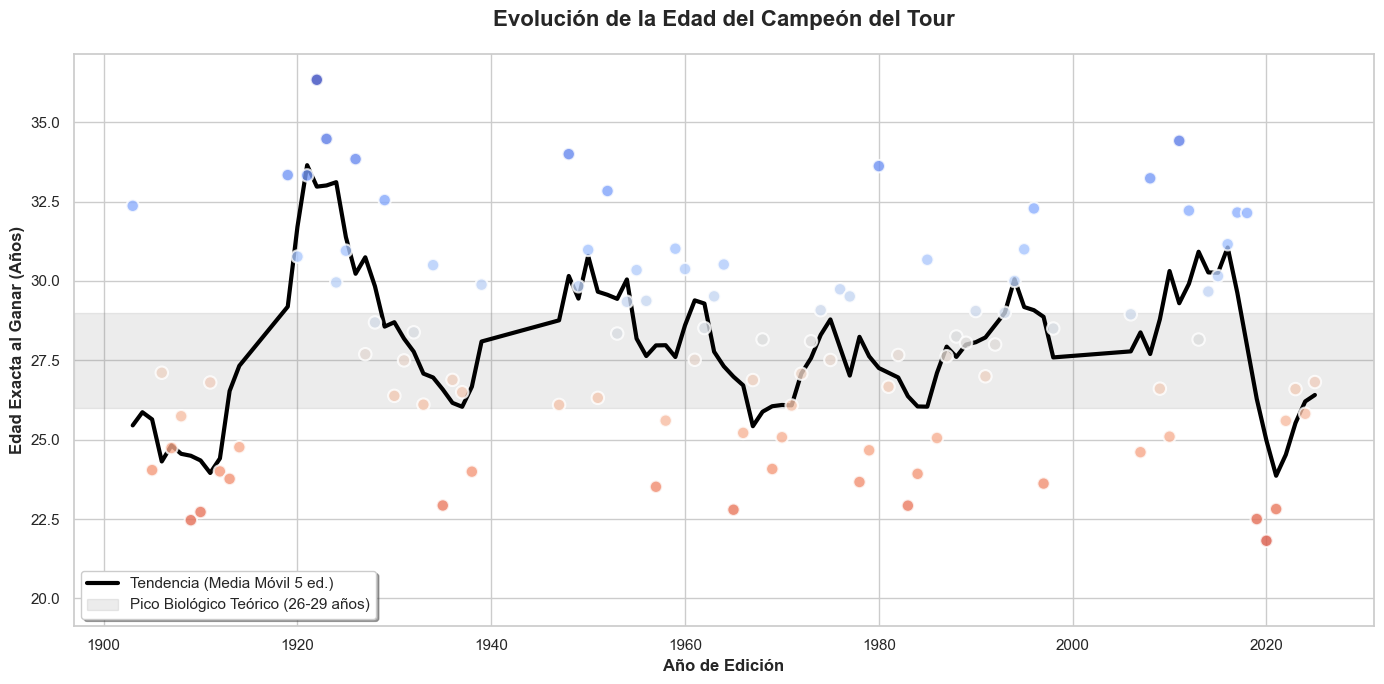

In [ ]:
# Gráfico 4: Evolución temporal de la edad del ganador
viz.plot_age_evolution(df_winners_feat)

* **Lectura del Gráfico:** Si seguimos la línea de tendencia (en negro) a lo largo de este siglo de historia, el gráfico nos revela cuatro grandes eras fisiológicas:
  1. **Los pioneros (Inicios del s. XX):** En las primeras ediciones, el caos y la supervivencia extrema de la prueba favorecían a ganadores muy jóvenes y temerarios.
  2. **El peso de la experiencia (Años 20 - 30):** A medida que la carrera se estructuraba, la tendencia fue subiendo claramente. El Tour se consolidó como una prueba de desgaste donde la madurez física y la veteranía eran indispensables para aguantar tres semanas.
  3. **La consolidación biológica (Años 40 - 2010):** Vemos cómo la línea se estabiliza y entra justo dentro de la franja gris (26-29 años). Es la época de la profesionalización clásica, coincidiendo exactamente con lo que la ciencia deportiva dictaba como el pico de plenitud muscular y mental.
  4. **Los "Niños Prodigio" (Actualidad):** La curva se desploma en la última década. Los puntos rojos finales rompen todas las reglas históricas. Hoy en día, la recolección masiva de datos, los potenciómetros y la nutrición milimétrica desde categorías junior han permitido que ciclistas de 21 o 22 años ganen el Tour, supliendo los tradicionales "años de experiencia" con pura optimización científica.

### La Evolución del Biotipo"
**Pregunta 5:** Si el Tour actual se decide en la alta montaña y los ciclistas son cada vez más jóvenes, ¿ha cambiado también su biotipo físico?

Para responder a esto, analizamos el Índice de Masa Corporal (BMI = Peso / Altura²) de los ganadores. En el ciclismo moderno, la métrica reina es el "w/kg" (vatios por kilo de peso); para subir más rápido, necesitas generar mucha potencia, pero pesando lo menos posible.

*Nota de Calidad de Datos:* Hemos filtrado el análisis desde 1950 en adelante. Los registros antropométricos de principios de siglo (antes de la Segunda Guerra Mundial) a menudo se basaban en estimaciones periodísticas y carecen del rigor médico necesario para un análisis estadístico serio.

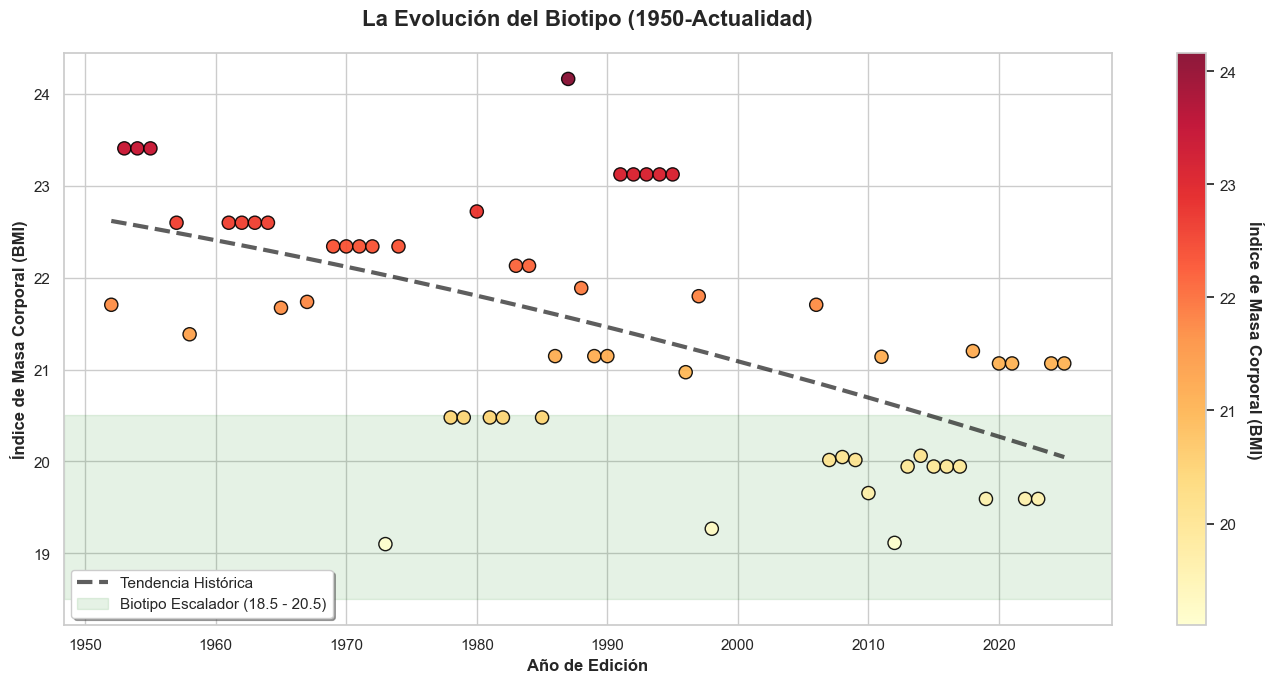

In [ ]:
# Gráfico 5: Evolución del Índice de Masa Corporal (BMI)
viz.plot_bmi_evolution(df_winners_feat)

* **Lectura del Gráfico:** La curva de regresión polinómica (línea punteada) dibuja una caída constante y espectacular. En los años 50 y 60, los ganadores solían tener un biotipo mucho más robusto (rondando un BMI de 23 o 24), ideal para rodar con potencia en el llano. Sin embargo, a medida que la carrera incluyó más desniveles, el cuerpo del ganador se fue "afilando". Hoy en día, todos los datos convergen en la franja verde inferior (BMI entre 18.5 y 20.5), rozando el límite de la delgadez extrema. El Tour ya no lo ganan corredores corpulentos, sino "pesos pluma" hiper-especializados.

## 4. Dimensión Geopolítica: La Globalización del Pelotón
**Pregunta 6:** ¿Ha dejado el Tour de ser una carrera de dominio exclusivamente europeo para convertirse en un evento verdaderamente global?

Para finalizar nuestro análisis, exploramos la procedencia de la "clase trabajadora" del Tour: los finalistas. Utilizando el dataset completo de ciclistas que lograron cruzar la meta en París (`tdf_finishers`), hemos analizado la nacionalidad de miles de corredores a lo largo de más de un siglo. 

Hemos agrupado a las cinco grandes potencias históricas del ciclismo europeo (Francia, Bélgica, Italia, España y Países Bajos) y las hemos comparado contra la proporción de ciclistas provenientes del "Resto del Mundo".

In [ ]:
# Gráfico 6: Evolución geopolítica de los finalistas (Área apilada al 100%)
viz.plot_globalization(df_finishers_clean)

AttributeError: module 'src.viz' has no attribute 'plot_globalization'

* **Lectura del Gráfico:** El gráfico de área apilada revela una transformación demográfica total. Hasta la década de 1970, el Tour era un feudo cerrado: casi el 90% de los ciclistas que lograban terminar la carrera provenían de las cinco potencias clásicas (dominadas abrumadoramente por la franja azul francesa y la negra belga). Sin embargo, a partir de los años 80 y 90, coincidiendo con la profesionalización y la televisión global, la franja gris ("Resto del Mundo") comienza a devorar el gráfico. Hoy en día, el pelotón es un crisol global donde las naciones históricas apenas representan a la mitad de los supervivientes.